# Climatology, anomalies and El Nino Southern Oscillation


Aim of this notebook:

- calculate El Nino Southern Oscillation index, and other monthly anomalies of climate variables
- understand and apply of xarray functions `slice`, `groupby`, `resample`, `rolling`
- investigate ENSO teleconnection effects yourself

## ENSO

El Nino refers to (warmer than usual) water temperature anomalies in the equatorial region to the Pacific, west of South America. The Southern Oscillation refers to atmospheric patterns over the same area. El Nino Southern Oscillation (ENSO) is the combination of both phenomena. There are different ENSO indices to monitor the Pacific Ocean. We are using the Nino 3.4 index, which is based on sea surface temperature. Here we use both terms (ENSO and Nino 3.4) interchangeably, but there are also other ways to calculate ENSO. Find more information on the indices and an example of the sea surface temperature (SST) anomalies [here](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni). 

## Climatology and monthly anomalies

So far, we have looked at yearly anomalies: the deviation of a yearly value from the time series average. Here, we will look at monthly anomalies. This is the deviation of a monthly value from the long-term average of that month. For this, we need to introduce another concept: **Climatology, or Mean Seasonal Cycle**: The climatology of a region refers to its average climate over a long time range, like 20-30 years. You know this from holiday planning, when checking: what is the expected average climate at your holiday destination for the month you are traveling? The real weather will be a little different, but unsually close to the expected climate.

Here is an example from the German Weather Service for Leipzig's temperature climatology.  This can also be called mean seasonal cycle of temperature (the black lines are the mean climate). The deviation of last year's temperature (in red) from this mean are the **monthly anomalies** of that year. They are calculated by subracting the mean seasonal cycle from the timeseries for each year, so you can see for each month if it was warmer or colder than average. The same can be done with daily or seasonal (3-month averaged) data to obtain corresponding daily or seasonal anomalies. We will calculate monthly anomalies below for the Nino index.

<img src="https://www.dwd.de/DWD/klima/kvo/en/kvo_en_3368_09_01_03_02.png">
Source: https://www.dwd.de/EN/weather/weather_climate_local/saxony/leipzig/_node.html

### Calculate the Nino 3.4 index

We are working with a different version (v2.1.1) of the ESDC which does not have a small datacube available, so you need to do your calculations on the scienfic cluster.


We determine the Nino 3.4 index by the sea surface temperature anomalies for the time period that is covered by the ESDC. The steps below are an example how to solve this task. Think about the steps before looking at the code - how would you implement them? You are welcome to try writing your own code first. 


1. Choose the variable `analysed_sst`
2. Select the region of the Nino3.4 (5N-5S, 170W-120W) from the ESDC
4. Resample the data to monthly data
5. Calculate the monthly anomalies in this region for each pixel (output dimension still 3D: time, lat, lon) by calculating the average monthly value and subtracting from the monthly data, using `groupby`
6. Calculate the mean anomaly of the whole area (dimension left: time) - remember area weighting by cosine of latitude
7. Smooth your data with a running window of 5 months using the `rolling` function
8. Identify strong El Nino and La Nina periods in the plot

You can use the `xarray` functions `sel`, `groupby`, `mean`, and `resample`

In [1]:
#%pip install --upgrade xarray zarr fsspec

In [2]:
#pip show fsspec

In [11]:
# import modules
import numpy as np
import zarr
import xarray as xr
import fsspec
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import dask.array as da

In [12]:
## This is a different cube than previously used, because we need a new variable of SST only available here
cube_path = '/software/databases/rsc4earth/EarthSystemDataCube/v2.1.1/esdc-8d-0.25deg-184x90x90-2.1.1.zarr/'

In [53]:
ds = xr.open_zarr(fsspec.get_mapper(cube_path), \
                  consolidated=True, chunks = {})
ds

<xarray.Dataset>
Dimensions:                            (time: 1840, lat: 720, lon: 1440, bnds: 2)
Coordinates:
  * lat                                (lat) float64 89.88 89.62 ... -89.88
    lat_bnds                           (lat, bnds) float64 dask.array<chunksize=(720, 2), meta=np.ndarray>
  * lon                                (lon) float64 -179.9 -179.6 ... 179.9
    lon_bnds                           (lon, bnds) float64 dask.array<chunksize=(1440, 2), meta=np.ndarray>
  * time                               (time) datetime64[ns] 1979-01-05 ... 2...
    time_bnds                          (time, bnds) datetime64[ns] dask.array<chunksize=(1840, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables: (12/79)
    Rg                                 (time, lat, lon) float32 dask.array<chunksize=(184, 90, 90), meta=np.ndarray>
    aerosol_optical_thickness_1600     (time, lat, lon) float64 dask.array<chunksize=(184, 90, 90), meta=np.ndarray>
    aerosol_optical_thickness_550      (time, lat, lon) float64 dask.array<chunksize=(184, 90, 90), meta=np.ndarray>
    aerosol_optical_thickness_670      (time, lat, lon) float64 dask.array<chunksize=(184, 90, 90), meta=np.ndarray>
    aerosol_optical_thickness_870      (time, lat, lon) float64 dask.array<chunksize=(184, 90, 90), meta=np.ndarray>
    air_temperature_2m                 (time, lat, lon) float32 dask.array<chunksize=(184, 90, 90), meta=np.ndarray>
    ...                                 ...
    water_mask                         (time, lat, lon) float32 dask.array<chunksize=(184, 90, 90), meta=np.ndarray>
    water_vapour                       (time, lat, lon) float32 dask.array<chunksize=(184, 90, 90), meta=np.ndarray>
    white_sky_albedo                   (time, lat, lon) float32 dask.array<chunksize=(184, 90, 90), meta=np.ndarray>
    white_sky_albedo_avhrr             (time, lat, lon) float32 dask.array<chunksize=(184, 90, 90), meta=np.ndarray>
    xch4                               (time, lat, lon) float64 dask.array<chunksize=(184, 90, 90), meta=np.ndarray>
    xco2                               (time, lat, lon) float64 dask.array<chunksize=(184, 90, 90), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x720x1440
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Your solution:

In [14]:
#1. Choose the variable analysed_sst
sst = ds['analysed_sst']

In [15]:
sst

<xarray.DataArray 'analysed_sst' (time: 1840, lat: 720, lon: 1440)>
dask.array<open_dataset-de436f372e2a4dce04cbb833e8da31ebanalysed_sst, shape=(1840, 720, 1440), dtype=float64, chunksize=(184, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) datetime64[ns] 1979-01-05 1979-01-13 ... 2018-12-31
Attributes: (12/18)
    Conventions:          CF-1.6
    comment:              ESA Sea Surface Temperature Climate Change Initiati...
    easting:              -180.0 degrees
    esa_cci_path:         /neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1/
    history:              Thu Apr 30 10:55:07 2020 - ESDL data cube generation
    institution:          Brockmann Consult GmbH, Germany
    ...                   ...
    time_coverage_end:    2016-12-30
    time_coverage_start:  1981-09-02
    units:                kelvin
    url:                  http://www.esa-sst-cci.org/
    valid_max:            4500
    valid_min:            -300

The longitude range 170W-120W should be correctly interpreted in the dataset. The range 170W-120W in degrees west can be converted to degrees east as follows:

- 170W is equivalent to 190E (360 - 170)
- 120W is equivalent to 240E (360 - 120)

In [16]:
# Select the region of the Nino3.4 (5N-5s, 170W-120W)
#check the longitude convention
if sst.lon.max() > 180:
    #Datasets use 0-360 degree convention
    print("dataset use 0-360 degree convention")
    nino34_region = sst.sel(lat=slice(5,-5), lon=slice(190, 240))
else:
    #Dataset uses -180 to 180 degree convention
    print("dataset use -180- 180 degree convention")
    nino34_region = sst.sel(lat=slice(5,-5), lon=slice(-170, -120))
    

dataset use -180- 180 degree convention


In [17]:
type(nino34_region)

xarray.core.dataarray.DataArray

In [18]:
nino34_region

<xarray.DataArray 'analysed_sst' (time: 1840, lat: 40, lon: 200)>
dask.array<getitem, shape=(1840, 40, 200), dtype=float64, chunksize=(184, 20, 90), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 4.875 4.625 4.375 4.125 ... -4.375 -4.625 -4.875
  * lon      (lon) float64 -169.9 -169.6 -169.4 -169.1 ... -120.6 -120.4 -120.1
  * time     (time) datetime64[ns] 1979-01-05 1979-01-13 ... 2018-12-31
Attributes: (12/18)
    Conventions:          CF-1.6
    comment:              ESA Sea Surface Temperature Climate Change Initiati...
    easting:              -180.0 degrees
    esa_cci_path:         /neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1/
    history:              Thu Apr 30 10:55:07 2020 - ESDL data cube generation
    institution:          Brockmann Consult GmbH, Germany
    ...                   ...
    time_coverage_end:    2016-12-30
    time_coverage_start:  1981-09-02
    units:                kelvin
    url:                  http://www.esa-sst-cci.org/
    valid_max:            4500
    valid_min:            -300

In [19]:
#Resample to monthly data
nino34_monthly = nino34_region.resample(time='M').mean()
nino34_monthly

<xarray.DataArray 'analysed_sst' (time: 480, lat: 40, lon: 200)>
dask.array<stack, shape=(480, 40, 200), dtype=float64, chunksize=(1, 20, 90), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 4.875 4.625 4.375 4.125 ... -4.375 -4.625 -4.875
  * lon      (lon) float64 -169.9 -169.6 -169.4 -169.1 ... -120.6 -120.4 -120.1
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2018-12-31
Attributes: (12/18)
    Conventions:          CF-1.6
    comment:              ESA Sea Surface Temperature Climate Change Initiati...
    easting:              -180.0 degrees
    esa_cci_path:         /neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1/
    history:              Thu Apr 30 10:55:07 2020 - ESDL data cube generation
    institution:          Brockmann Consult GmbH, Germany
    ...                   ...
    time_coverage_end:    2016-12-30
    time_coverage_start:  1981-09-02
    units:                kelvin
    url:                  http://www.esa-sst-cci.org/
    valid_max:            4500
    valid_min:            -300

In [20]:
# calculate the monthly climatology
monthly_climatology_nino34 = nino34_monthly.groupby('time.month').mean()
monthly_anomalies_nino34 = nino34_monthly.groupby('time.month') - monthly_climatology_nino34

/home/sc.uni-leipzig.de/da22digu/.conda/envs/env_data/lib/python3.11/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]


In [21]:
#calculate the mean anomaly of the whole area with area weighting
weights = np.cos(np.deg2rad(nino34_monthly.lat))
weights.name = "weights"
mean_anomaly_nino34 = (monthly_anomalies_nino34 * weights).mean(dim=['lat', 'lon'])

In [22]:
#smooth the data with a running windows of 5 months
smoothed_anomaly_nino34 = mean_anomaly_nino34.rolling(time=5, center=True).mean()

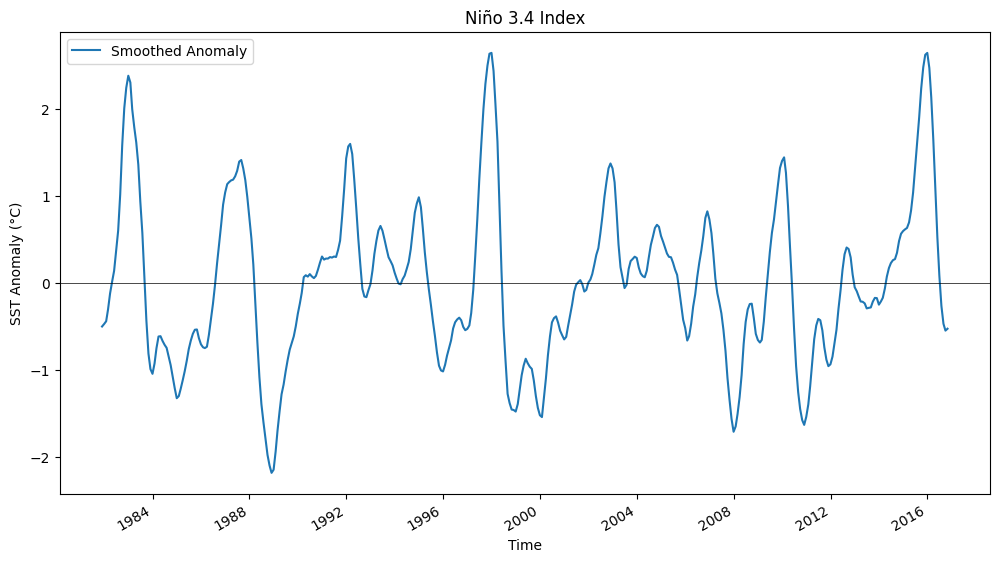

In [23]:
# Plot the results
plt.figure(figsize=(12, 6))
smoothed_anomaly_nino34.plot(label='Smoothed Anomaly')
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Niño 3.4 Index')
plt.xlabel('Time')
plt.ylabel('SST Anomaly (°C)')
plt.legend()
plt.show()

In [24]:
# Identify strong El Nino and La Nina periods
el_nino_threshold = 0.5
la_nina_threshold = -0.5

In [25]:
el_nino_periods = smoothed_anomaly_nino34.where(smoothed_anomaly_nino34 > el_nino_threshold, drop=True)
la_nina_periods = smoothed_anomaly_nino34.where(smoothed_anomaly_nino34 < la_nina_threshold, drop=True)
#print(f"Strong El Niño periods: \n {el_nino_periods.time.values} \n Strong La Niña periods: \n {la_nina_periods.time.values} ")


The thresholds of 0.5°C for El Niño and -0.5°C for La Niña are commonly used in climate science to identify significant anomalies in the Niño 3.4 index. These thresholds are based on the definitions provided by organizations such as the National Oceanic and Atmospheric Administration (NOAA).

- El Niño: A period is considered an El Niño event if the Niño 3.4 index is greater than +0.5°C for a sustained period (typically 5 consecutive overlapping 3-month seasons).
- La Niña: A period is considered a La Niña event if the Niño 3.4 index is less than -0.5°C for a sustained period (typically 5 consecutive overlapping 3-month seasons).

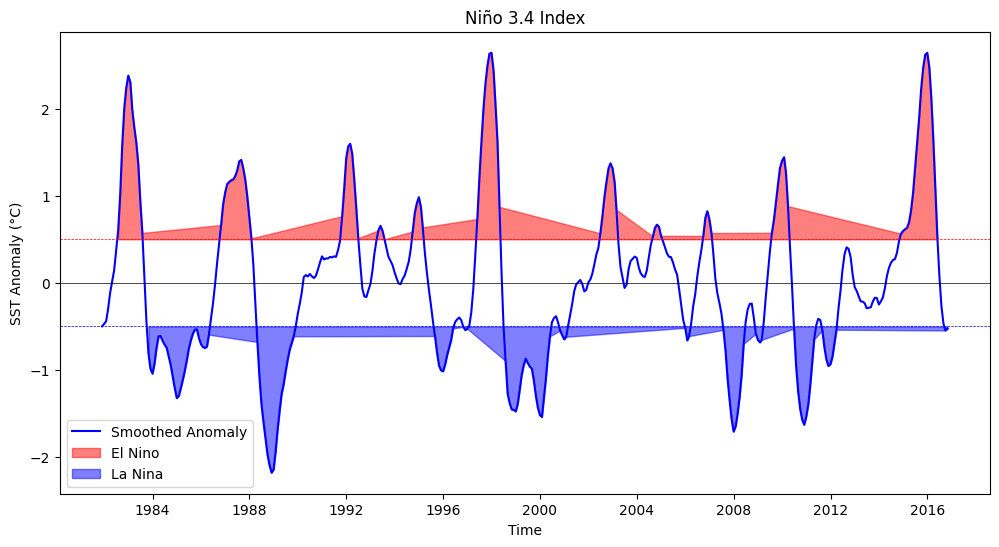

In [26]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(smoothed_anomaly_nino34.time, smoothed_anomaly_nino34, label='Smoothed Anomaly', color='blue')
plt.fill_between(el_nino_periods.time, el_nino_periods, el_nino_threshold, color='red', alpha=0.5, label='El Nino')
plt.fill_between(la_nina_periods.time, la_nina_periods, la_nina_threshold, color='blue', alpha=0.5, label='La Nina')
plt.axhline(0, color='black', linewidth=0.5)
plt.axhline(el_nino_threshold, color='red', linestyle='--', linewidth=0.5)
plt.axhline(la_nina_threshold, color='blue', linestyle='--', linewidth=0.5)
plt.title('Niño 3.4 Index')
plt.xlabel('Time')
plt.ylabel('SST Anomaly (°C)')
plt.legend()
plt.show()

### .. and/or: Provided solution, also to cross check or if you get stuck

In [28]:
# 1. Select the variable analysed_sst in the area of Nino3.4
ds_nino = ds.analysed_sst.sel(lat=slice(5,-5), lon=slice(-170, -120))

In [30]:
# 2. + 3. Computue the average of each month of the SST in the area of Nino3.4
monthly_sst = ds_nino.resample(time='M').mean()

# you can plot one example pixel to see what's happening
#ds_enso.sel(lat=0,lon=145,method='nearest').plot()
#monthly_sst.sel(lat=0,lon=145,method='nearest').plot()

In [31]:
# 4. Determine the deviation (=anomlay) of SSTs from the average SSTs for each month

# Compute the mean seasonla cycle, that is the average SST for each month (all januaries, febuaries,...)
average_monthly_sst = ds_nino.groupby('time.month').mean()

#average_monthly_sst.sel(lat=0,lon=145,method='nearest').plot()

# compute the anomalies
anomalies = monthly_sst.groupby('time.month') - average_monthly_sst

#anomalies.sel(lat=0,lon=145,method='nearest').plot()

/home/sc.uni-leipzig.de/da22digu/.conda/envs/env_data/lib/python3.11/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]


In [32]:
# 5. Calculate the mean anomaly across the whole Nino3.4 area (don't forget to weight the grid cells by latitude, according to their area)
# You can use the .weighted() function from Xarray (see https://docs.xarray.dev/en/stable/examples/area_weighted_temperature.html)
weights = np.cos(np.deg2rad(anomalies.lat))
weights.name = "weights"

sst_anomaly = anomalies.weighted(weights).mean(('lat', 'lon'))

In [33]:
# 6. Smooth the time series with a 5 month window. There is a rolling window function in Xarray:
sst_anomaly_5month = sst_anomaly.rolling(time=5, center=True).mean()

### We can now visualize the Nino 3.4 region and see how ENSO develops and goes through different phases over the years.  

ENSO based on Nino3.4 is usually computed as a 5-month rolling average to smooth out some smaller fluctuations. As you can see below, the effect is minimal, but removes short-term variability that may not be so impactful for global climate, because it gets "diluted" at larger scales.

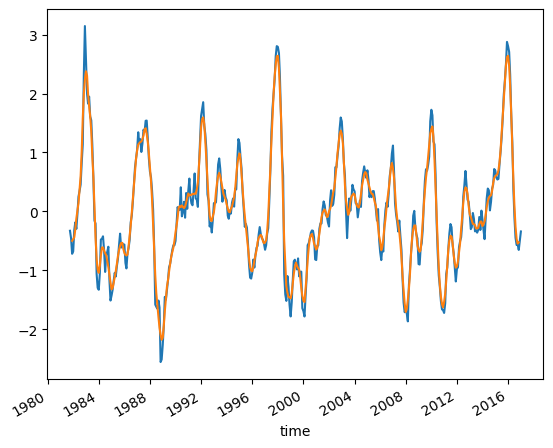

In [36]:
# for the aggregated sst anomaly timeseries
mean_anomaly_nino34.plot()
smoothed_anomaly_nino34.plot()

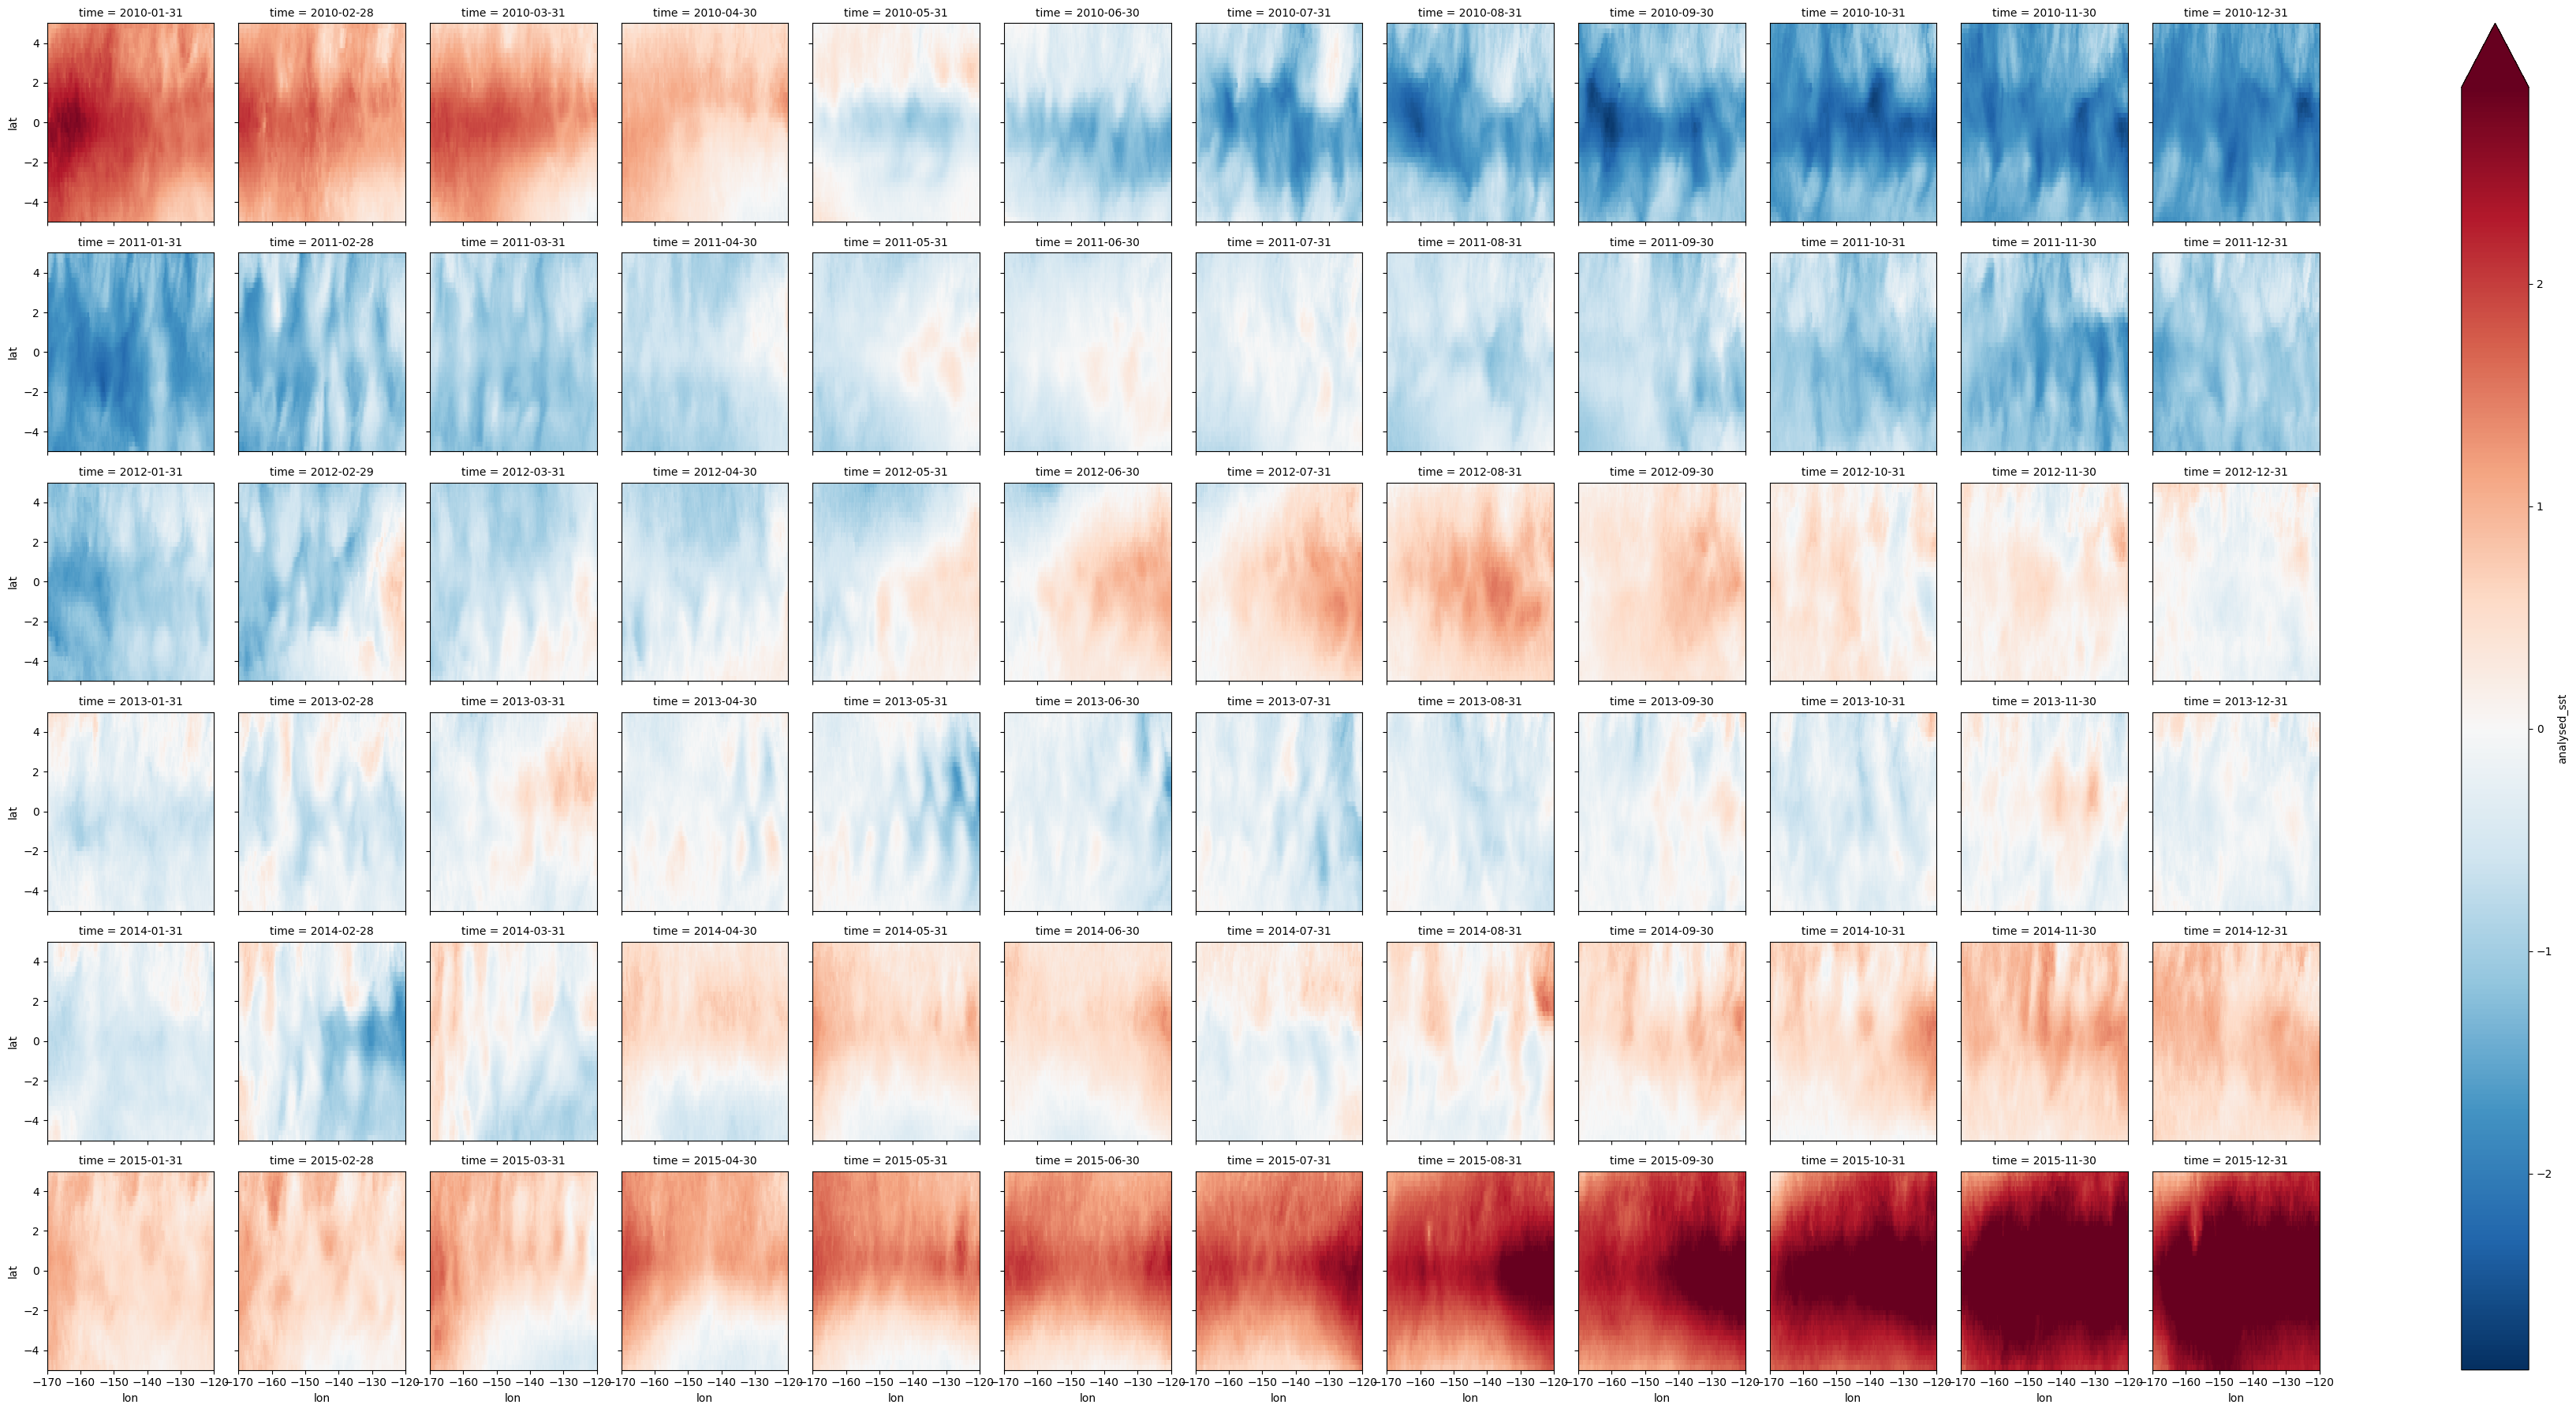

In [38]:
# for the SST fields over the nino3.4 area
monthly_anomalies_nino34.sel(time=slice("2010","2015")).plot(x='lon', y='lat', col='time', col_wrap=12, robust=True)

**Question**: Briefly describe: What does this plot show? What do rows, columns represent, what is seen in the panels? What does the color scale mean? Do you identify time points of El Nino / La Nina? 

### Plot description
   
The plot consists of multiple panels arranged in a grid. Each panel represents a spatial map over the coordinates 5N-5S, 170W-120W (lat=-5, 5 and lon=-170, -120), which locates the map on the Pacific Ocean between 2010 and 2015. The plot provides the temporal evolution from El Niño/La Niña in this specific location. 

The columns correspond to different time points (each labeled with a specific date), and the rows represent years. Regarding the colors, there is a color bar which indicates values ranging from blue (negative anomalies) to red (positive anomalies). The variable represented is the Sea Surface Temperature (SST) anomalies to study El Niño and La Niña. The red areas suggest warming (El Niño conditions), while the blue ones correspond to cooling (La Niña conditions).

It is possible to identify the anomalies based on the intensity of the colors. The strong red shedding graphs on the bottom (right side), indicate a significant warming of the ocean. These graphs corresponds to the years: 2015-07-31, 2015-08-31, 2015-09-30, 2015-10-31, 2015-11-30, and 2015-12-31. The graphs observed in early 2011 and 2012, where the blue shading is dominant, indicating a cooling trend, refer to a strong La Niña.


# Correlate ENSO with climate variables in an affected region

Now you can plot the Nino3.4 anomaly against other vegetation and meteorologic variables in other areas of Earth (e.g. precipitation in Australia or Florida, temperature in Africa or South America, or even gross primary productivity in South America..). Feel highly encouraged to try different variables and regions and be prepared to share your results in the next exercise.

Take a look at the regions most affected by ENSO below or here: https://en.wikipedia.org/wiki/El_Ni%C3%B1o%E2%80%93Southern_Oscillation

Choose a region you want to focus on. First we compute an average timeseries over that region, as done above for SST, and compute a correlation between this timeseries and Nino3.4. 
Then we also correlate Nino3.4  to the timeseries at every pixel of your map, creating a correlation map over your region.

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/NOAA_Nino.jpg"> <img src="https://upload.wikimedia.org/wikipedia/commons/9/97/NOAA_Nina.jpg">

**TODO:** Which variables could ENSO affect? Choose a variable and region from the data cube where you could expect to see an effect.

For your region and variable of interest, calculate separately both the monthly average, as well as the monthly anomalies. Aggregate each of them over your region (just like we did above for the sst anomalies), so you have one timeseries left. Calculate the correlation between Nino3.4  and monthly average, as well as Nino3.4  and monthly anomlies - do you see a difference? You can use the function `xr.corr` for this, using `xr.corr(x,y,dim="time")` where x and y are the timeseries of Nino3.4  and your selected variable. Plot them together in scatter plot and line plots to investigate.

Briefly comment on your results: What correlation do you find? Which one is stronger? 

--->this is just put together the two times series --disperssion diagram, and together the time sereies

**Based on this reference from the [National Weather Service](https://www.weather.gov/mhx/ensowhat#:~:text=ENSO%20is%20one%20of%20the,and%20precipitation%20across%20the%20globe.), Enso affects mostly temperature and precipitation. Here I will visualize precipitation**.

In this problem, I will set Colombia. The country is mainly influenced by the Niño 1+2 (80°W–90°W, 0°–10°S) and Niño 3 (90°W–150°W, 5°N–5°S) regions. Here I shall work with **the Niño 1+2 (80°W–90°W, 0°–10°S)**

References: 

1. [National Weather Service](https://www.weather.gov/mhx/ensowhat#:~:text=ENSO%20is%20one%20of%20the,and%20precipitation%20across%20the%20globe.)
2. [Analysis of ENSO-Driven Variability, and Long-Term Changes, of Extreme Precipitation Indices in Colombia, Using the Satellite Rainfall Estimates CHIRPS](https://www.mdpi.com/2073-4441/14/11/1733)

In [40]:
#1. Choose the variable analysed_sst
precipitation = ds['precipitation']

In [43]:
# Print the minimum and maximum values of the latitude and longitude coordinates
print("Latitude range in the original dataset:")
print(precipitation.lat.min().values, precipitation.lat.max().values)

print("Longitude range in the original dataset:")
print(precipitation.lon.min().values, precipitation.lon.max().values)

nino12_colombia = precipitation.sel(lat=slice(0, -10), lon=slice(-90, -80))
print("Selected Dataset After Fix:")
print(nino12_colombia)

# Resample to monthly data
nino12_monthly = nino12_colombia.resample(time='M').mean()
print("Monthly Resampled Data:")
print(nino12_monthly)

# Calculate the monthly climatology
monthly_climatology_nino12 = nino12_monthly.groupby('time.month').mean()
print("Monthly Climatology:")
print(monthly_climatology_nino12)

# Calculate monthly anomalies
monthly_anomalies_nino12 = nino12_monthly.groupby('time.month') - monthly_climatology_nino12
print("Monthly Anomalies:")
print(monthly_anomalies_nino12)

# Calculate the mean anomaly of the whole area with area weighting
weights = np.cos(np.deg2rad(nino12_monthly.lat))
weights.name = "weights"
mean_anomaly_nino12 = (monthly_anomalies_nino12 * weights).mean(dim=['lat', 'lon'])

# Smooth the anomaly
smoothed_anomaly_nino12 = mean_anomaly_nino12.rolling(time=3, center=True, min_periods=1).mean()

#smoothed_anomaly = mean_anomaly.rolling(time=5, center=True).mean()
#print("Smoothed Anomaly:")
#print(smoothed_anomaly_nino12)

# Plot the smoothed anomaly
#plt.figure(figsize=(12, 6))
#smoothed_anomaly_nino12.plot()
#plt.title('Smoothed Anomaly for El Niño and La Niña')
#plt.xlabel('Time')
#plt.ylabel('Anomaly')
#plt.grid(True)
#plt.show()

Latitude range in the original dataset:
-89.875 89.875
Longitude range in the original dataset:
-179.875 179.875
Selected Dataset After Fix:
<xarray.DataArray 'precipitation' (time: 1840, lat: 40, lon: 40)>
dask.array<getitem, shape=(1840, 40, 40), dtype=float32, chunksize=(184, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -0.125 -0.375 -0.625 -0.875 ... -9.375 -9.625 -9.875
  * lon      (lon) float64 -89.88 -89.62 -89.38 -89.12 ... -80.62 -80.38 -80.12
  * time     (time) datetime64[ns] 1979-01-05 1979-01-13 ... 2018-12-31
Attributes:
    ID:                        71
    esa_cci_path:              
    long_name:                 Precipitation
    orig_attrs:                {'comment': 'Precipitation based on the GPCP d...
    orig_version:              
    project_name:              GPCP
    time_coverage_end:         2015-01-05
    time_coverage_resolution:  P8D
    time_coverage_start:       1980-01-05
    units:                     mm/day
    url:    

/home/sc.uni-leipzig.de/da22digu/.conda/envs/env_data/lib/python3.11/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]


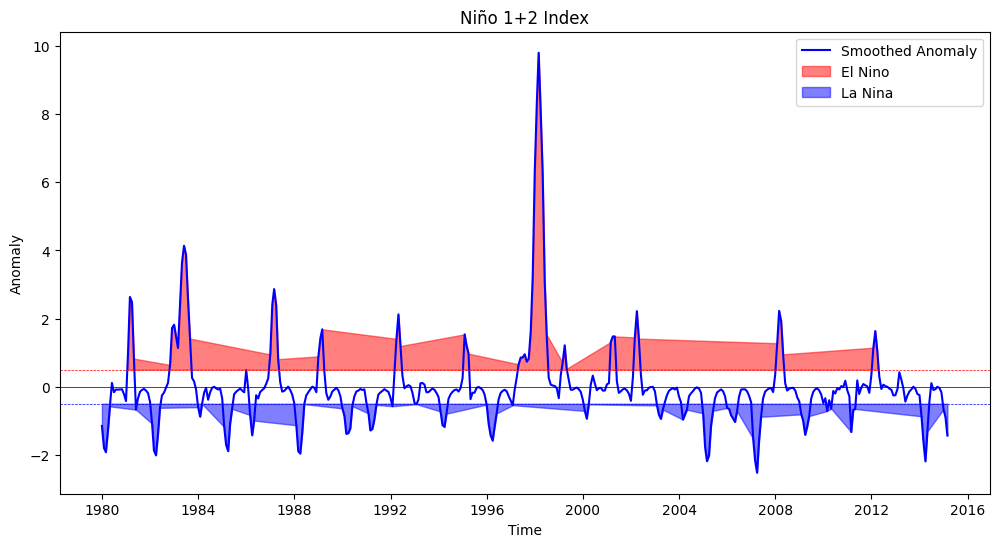

In [45]:
# Identify strong El Nino and La Nina periods
el_nino_threshold = 0.5
la_nina_threshold = -0.5
el_nino_periods = smoothed_anomaly_nino12.where(smoothed_anomaly_nino12 > el_nino_threshold, drop=True)
la_nina_periods = smoothed_anomaly_nino12.where(smoothed_anomaly_nino12 < la_nina_threshold, drop=True)

plt.figure(figsize=(12, 6))
plt.plot(smoothed_anomaly_nino12.time, smoothed_anomaly_nino12, label='Smoothed Anomaly', color='blue')
plt.fill_between(el_nino_periods.time, el_nino_periods, el_nino_threshold, color='red', alpha=0.5, label='El Nino')
plt.fill_between(la_nina_periods.time, la_nina_periods, la_nina_threshold, color='blue', alpha=0.5, label='La Nina')
plt.axhline(0, color='black', linewidth=0.5)
plt.axhline(el_nino_threshold, color='red', linestyle='--', linewidth=0.5)
plt.axhline(la_nina_threshold, color='blue', linestyle='--', linewidth=0.5)
plt.title('Niño 1+2 Index')
plt.xlabel('Time')
plt.ylabel('Anomaly')
plt.legend()
plt.show()

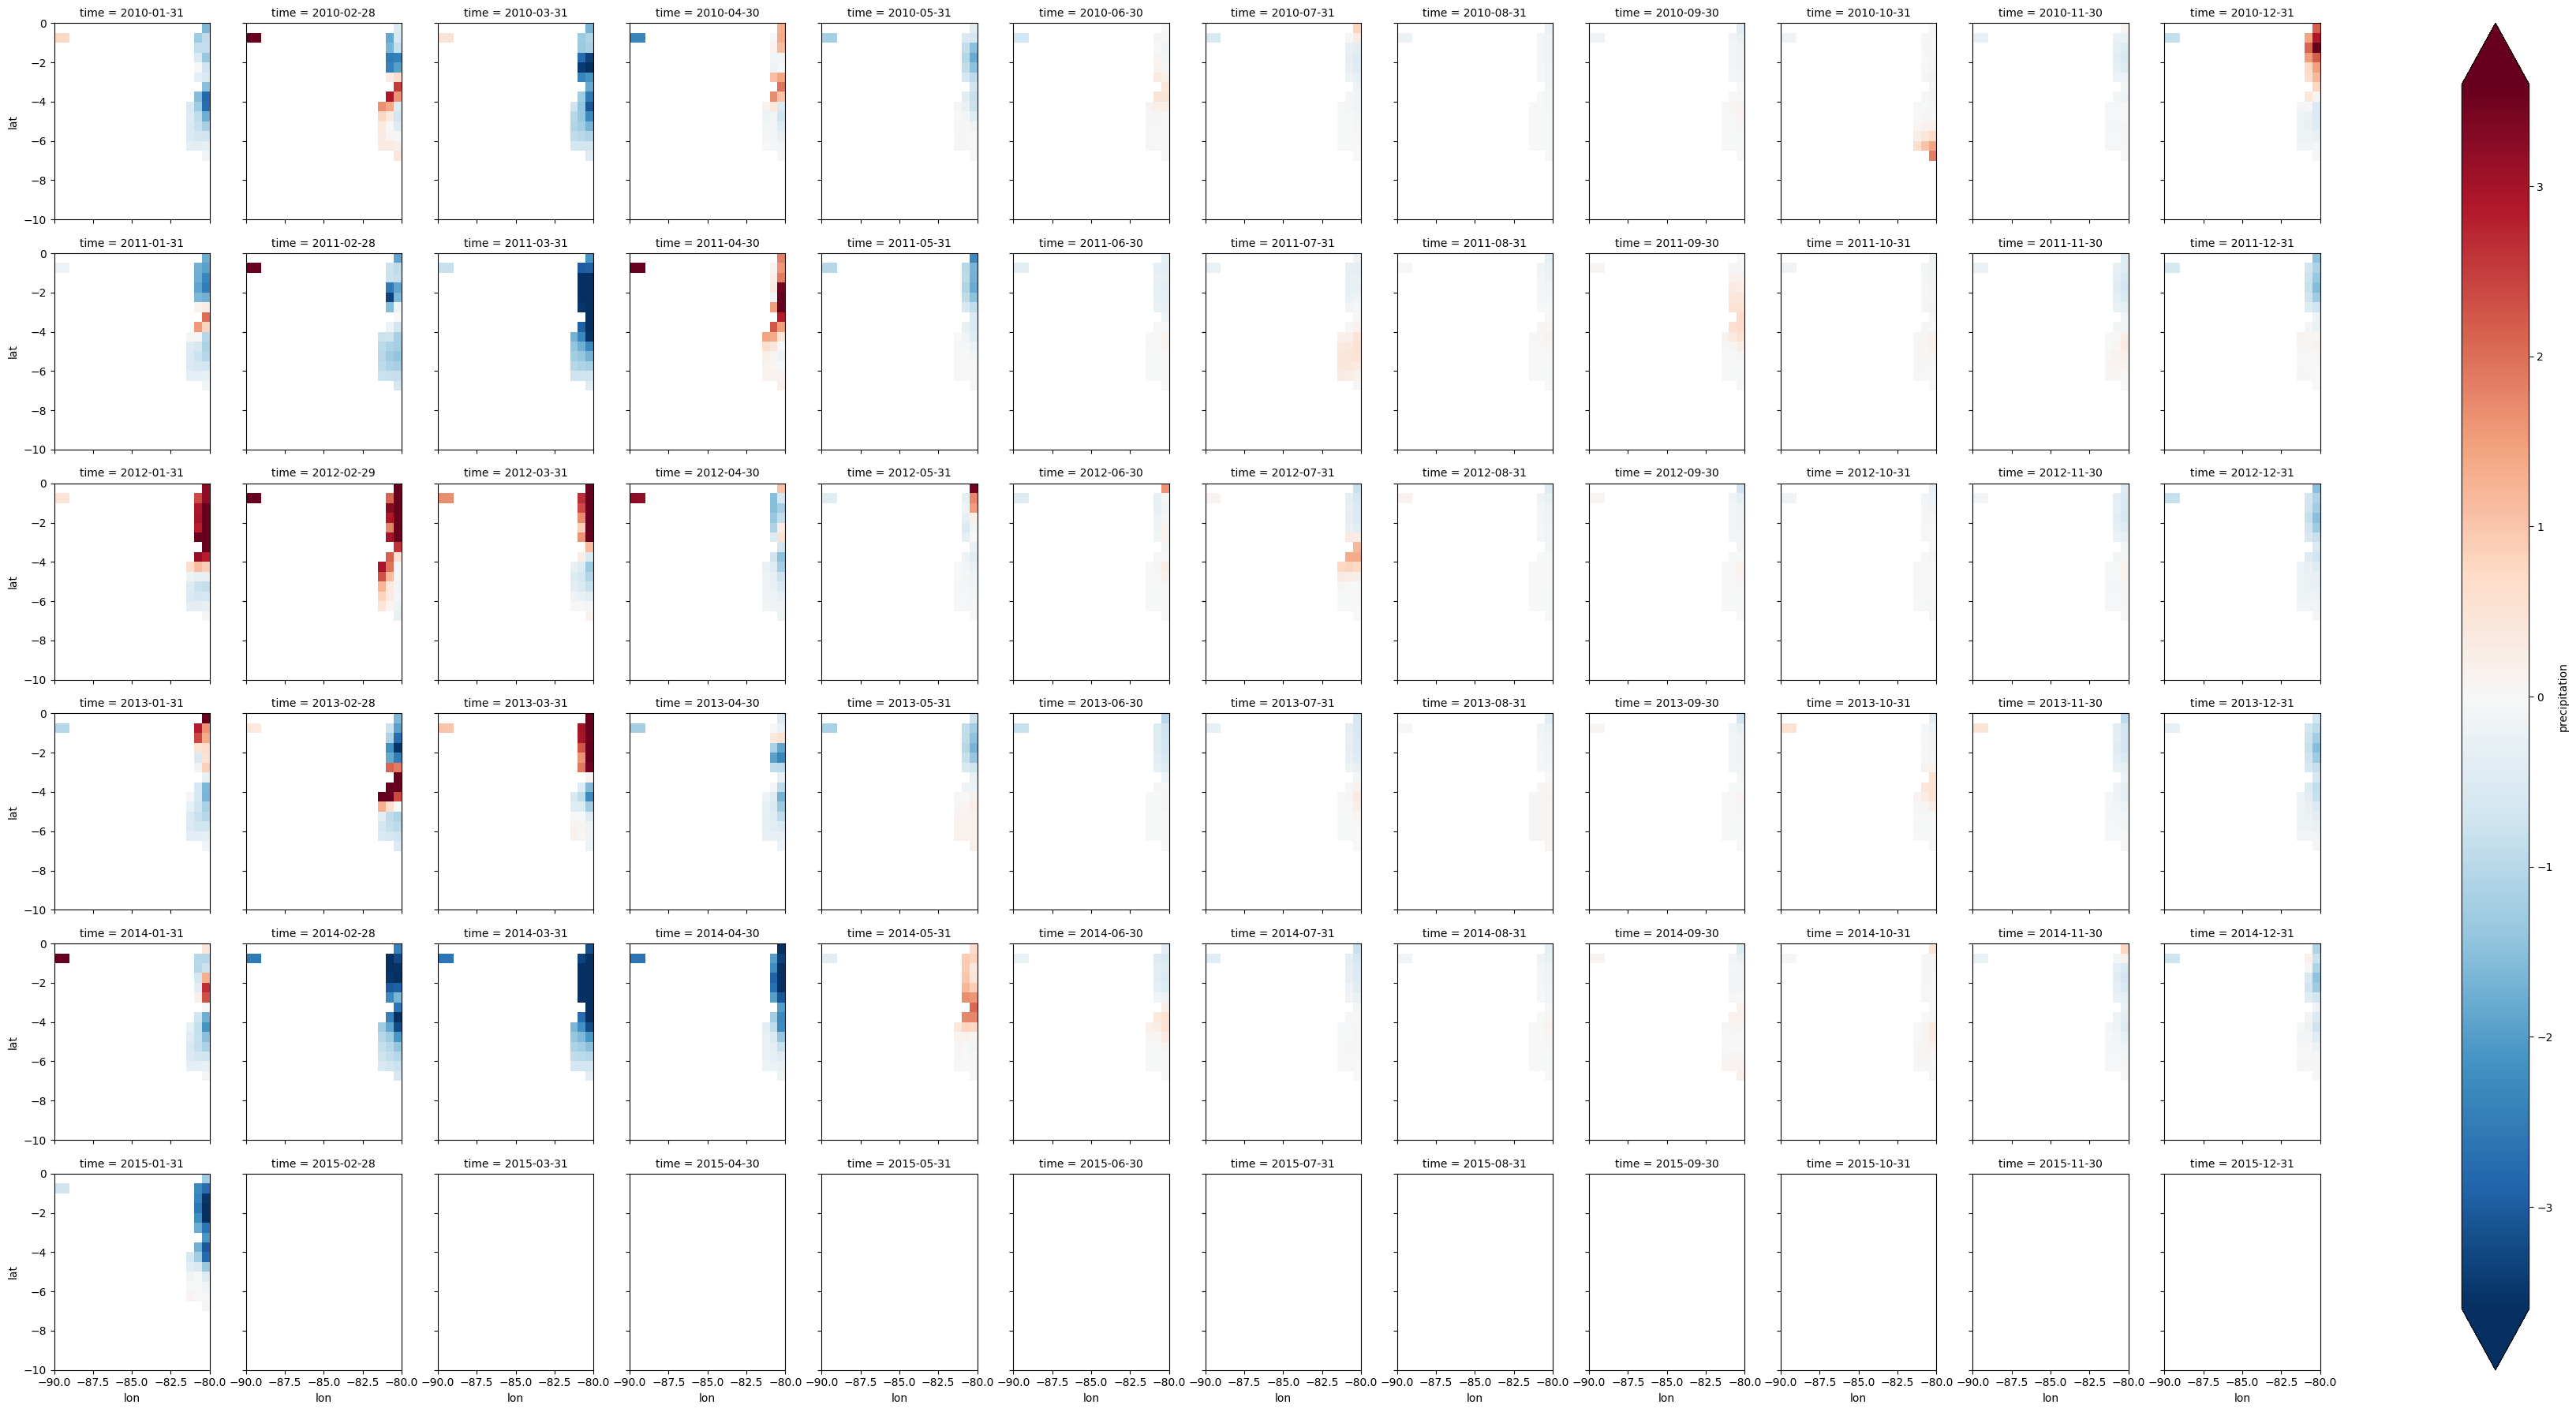

In [46]:
monthly_anomalies_nino12.sel(time=slice("2010","2015")).plot(x='lon', y='lat', col='time', col_wrap=12, robust=True)

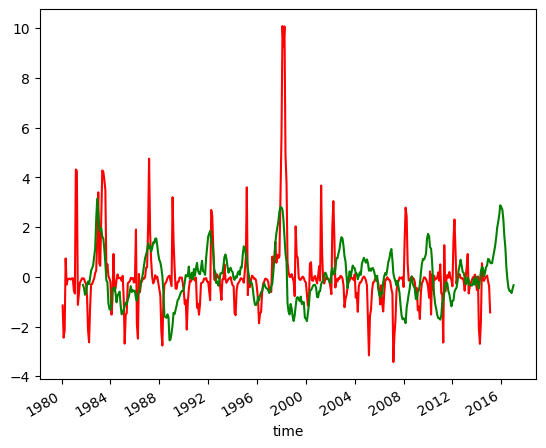

In [50]:
# for the aggregated sst anomaly timeseries
mean_anomaly_nino12.plot(color='red', label= 'Mean anomaly Niño 1+2')
mean_anomaly_nino34.plot(color = 'green', label='Mean anomaly Niño 3.4')

Correlation coefficient: 0.32995636222288


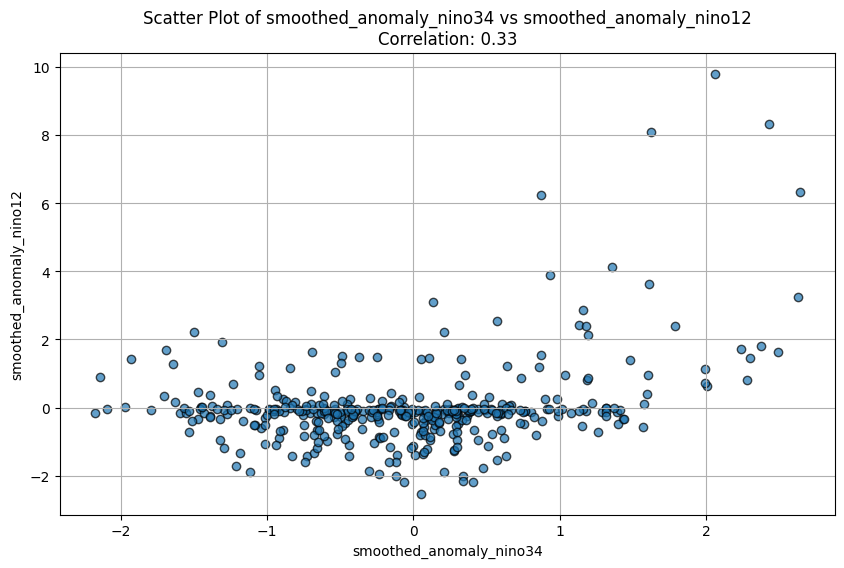

In [48]:
correlation = xr.corr(smoothed_anomaly_nino34, smoothed_anomaly_nino12, dim="time")
print(f"Correlation coefficient: {correlation.values}")

# Plot scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(smoothed_anomaly_nino34, smoothed_anomaly_nino12, alpha=0.7, edgecolors='k')
plt.title(f'Scatter Plot of smoothed_anomaly_nino34 vs smoothed_anomaly_nino12\nCorrelation: {correlation.values:.2f}')
plt.xlabel('smoothed_anomaly_nino34')
plt.ylabel('smoothed_anomaly_nino12')
plt.grid(True)
plt.show()

### Why work with anomalies?

**Question:** What difference did you see when using anomalies of the variable for correlation analysis? Why do you think this is? Why use anomalies in this analysis?


- addimentional variables
- compare it with differents variables
- simplify the time series,by standarizing the units and comparing the effects in differents areas

The correlation coefficient is 0.33, indicating a weak to moderate positive linear relationship between the smoothed anomalies in Niño 3.4 and Niño 1+2 regions. This means that while there is a tendency for these anomalies to move together, the relationship is not strong or consistent across the entire dataset.

Events in Niño 3.4 and Niño 1+2 regions may be influenced by different climate dynamics. Additionally they share some common patterns: A positive correlation still suggests that these regions are not entirely independent; they might share some drivers, but other factors likely influence them individually.

## Correlate the Nino3.4 index against other variables - pixel-wise, on a map


Depending which area you chose to look at, you saw no strong correlation between the Nino3.4 index and the averaged variables in ENSO-affected regions - that's possible and not a mistake. This may be due to the fact that there is actually only a small correlation between the sizes, i. e. ENSO anomalies only cause small precipitation or temperature anomalies in those regions.

**Question:** What could be other reasons for it?


**TODO:** Correlate the ENSO index with each pixel over the area you selected above, instead of the area average. Do you find any differences across the map? Briefly comment on your results.

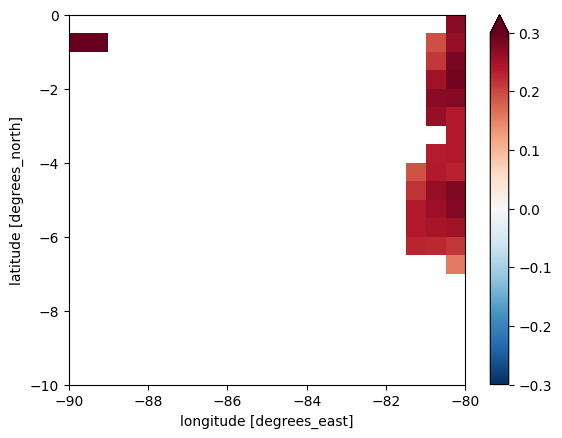

In [58]:
map_prec_sst_anom_cor = xr.corr(
    monthly_anomalies_nino12, mean_anomaly_nino34,
    dim = "time"
)

map_prec_sst_anom_cor.plot(vmin=-0.3, vmax=0.3, center=0, cmap='RdBu_r')


- The correlation shows stronger in one side of the plot, maybe a direct responde to ENSO events
- Maybe this indicates that this side of the region responds in the same phase as ENSO events
